In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('private_banks.csv', index_col=['date'])
prices.head(10)

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
03-01-2018   926.325012    315.000000   1000.099976   560.450012   
04-01-2018   929.950012    314.700012   1000.400024   559.900024   
05-01-2018   931.799988    312.899994   1003.049988   563.250000   
08-01-2018   930.299988    314.149994   1006.099976   565.450012   
09-01-2018   931.849976    312.600006   1009.750000   565.299988   
10-01-2018   932.099976    312.000000   1002.250000   562.799988   
11-01-2018   936.275024    309.500000   1017.650024   558.750000   
12-01-2018   932.650024    317.700012   1023.349976   555.099976   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
03-01-2018    1630.250000     107.699997      54.150002  162.181824   
04-01-2018    1646.599976     108.650002      54.549999  160.636368   
05-01-2018    1698.199951     112.099998      58.250000  160.000000   
08-01-2018    1719.900024     115.550003      63.349998  159.681824   
09-01-2018    1725.050049     115.150002      62.799999  158.909088   
10-01-2018    1734.099976     113.150002      63.250000  159.318176   
11-01-2018    1700.300049     114.000000      68.550003  159.045456   
12-01-2018    1705.250000     115.050003      67.500000  158.863632   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
03-01-2018  514.900024  
04-01-2018  517.400024  
05-01-2018  539.700012  
08-01-2018  545.450012  
09-01-2018  538.900024  
10-01-2018  529.500000  
11-01-2018  533.599976  
12-01-2018  530.750000

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
30-12-2020  1432.500000    528.750000   2017.949951   625.099976   
31-12-2020  1436.300049    535.049988   1995.599976   620.450012   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
30-12-2020     899.049988      67.250000      36.650002  178.100006   
31-12-2020     894.950012      66.699997      37.049999  180.100006   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
30-12-2020  232.500000  
31-12-2020  231.050003

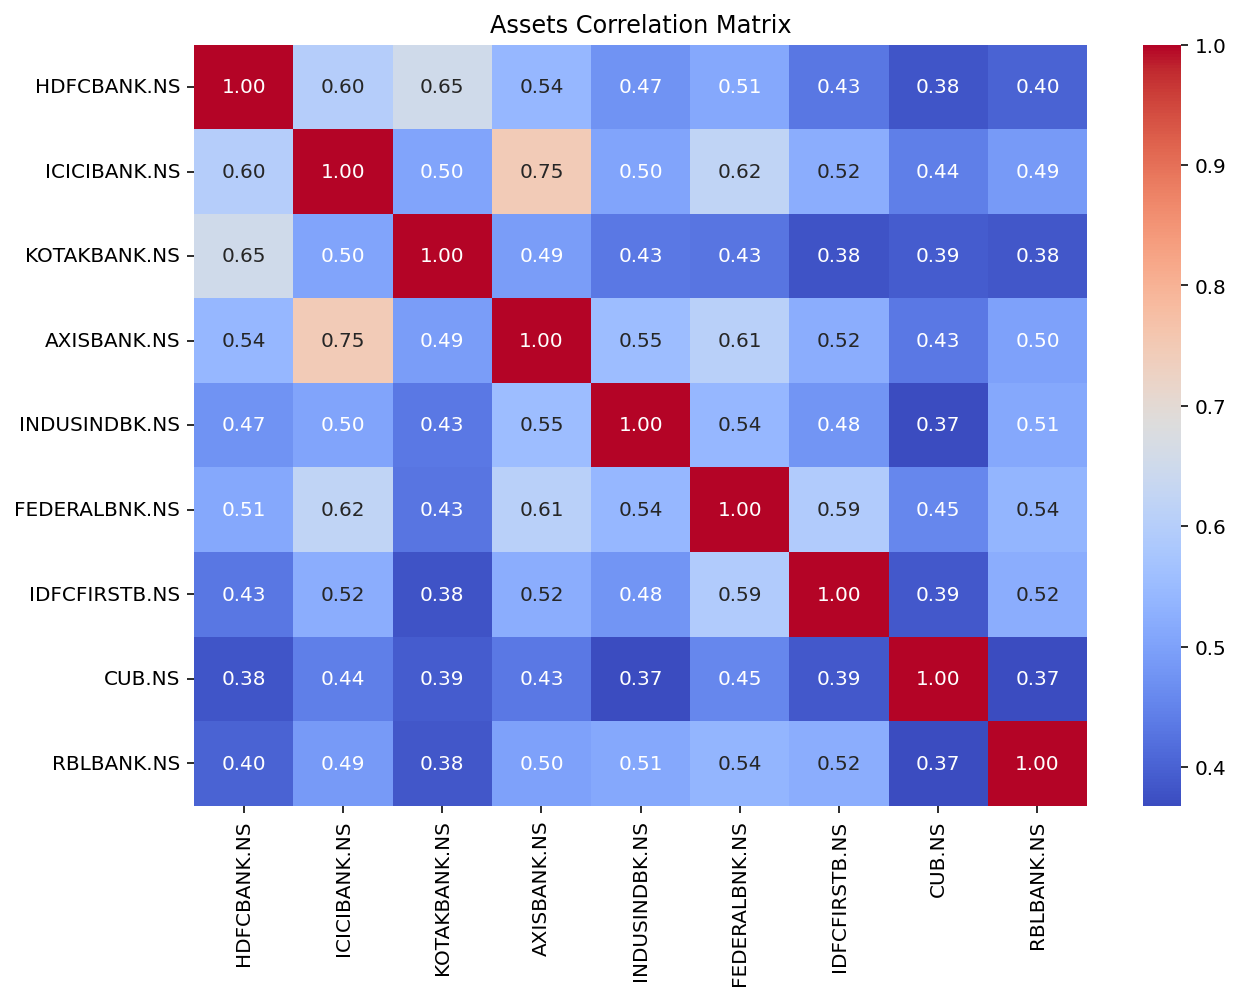

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDFCBANK.NS', 'KOTAKBANK.NS'), ('AXISBANK.NS', 'CUB.NS'), ('FEDERALBNK.NS', 'IDFCFIRSTB.NS')]


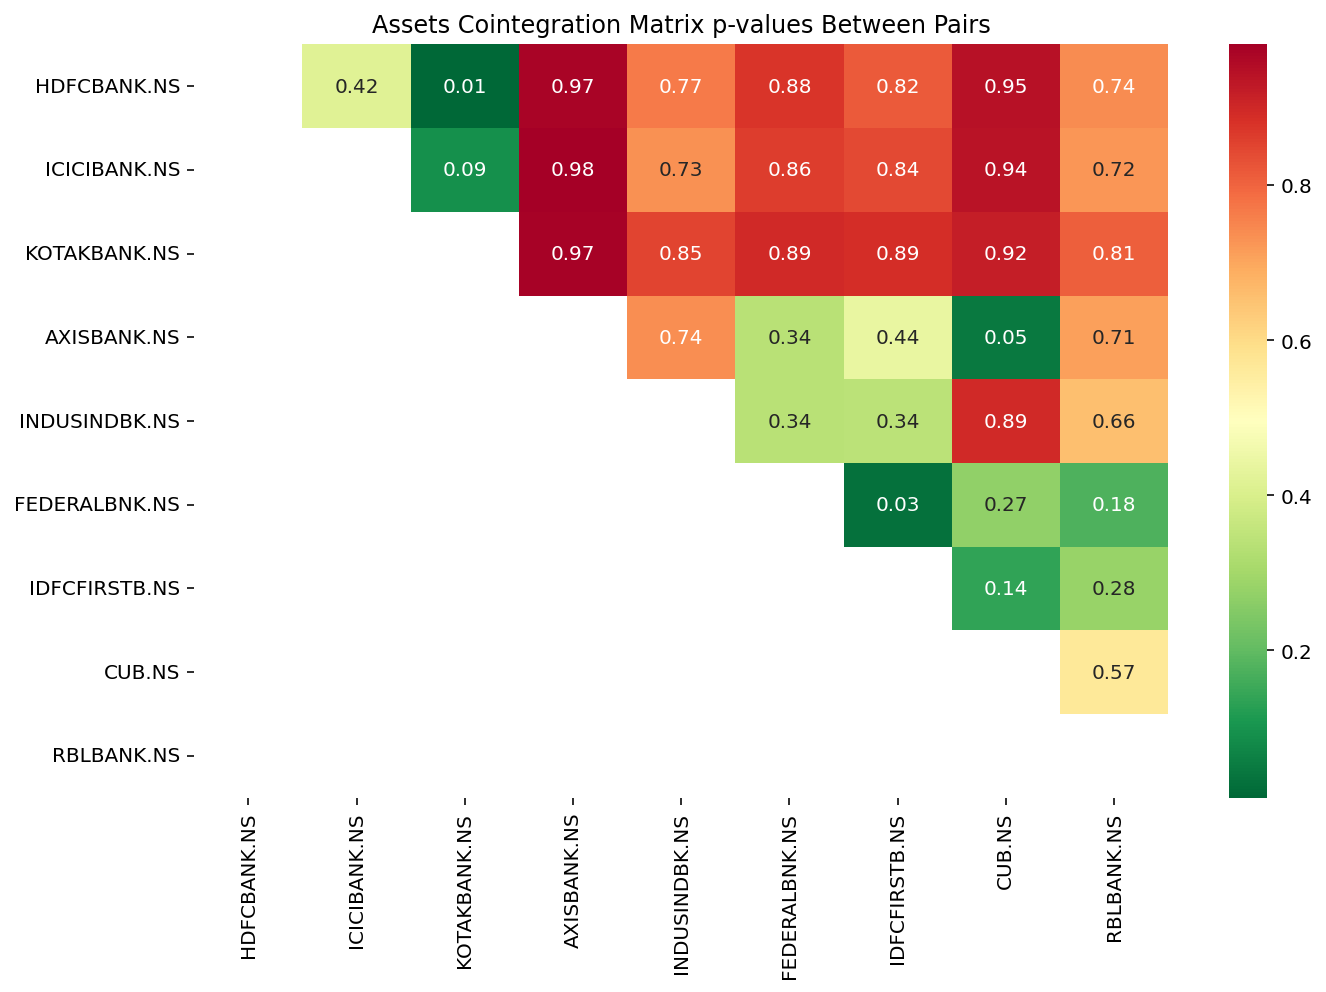

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'AXISBANK.NS'
asset2 = 'CUB.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

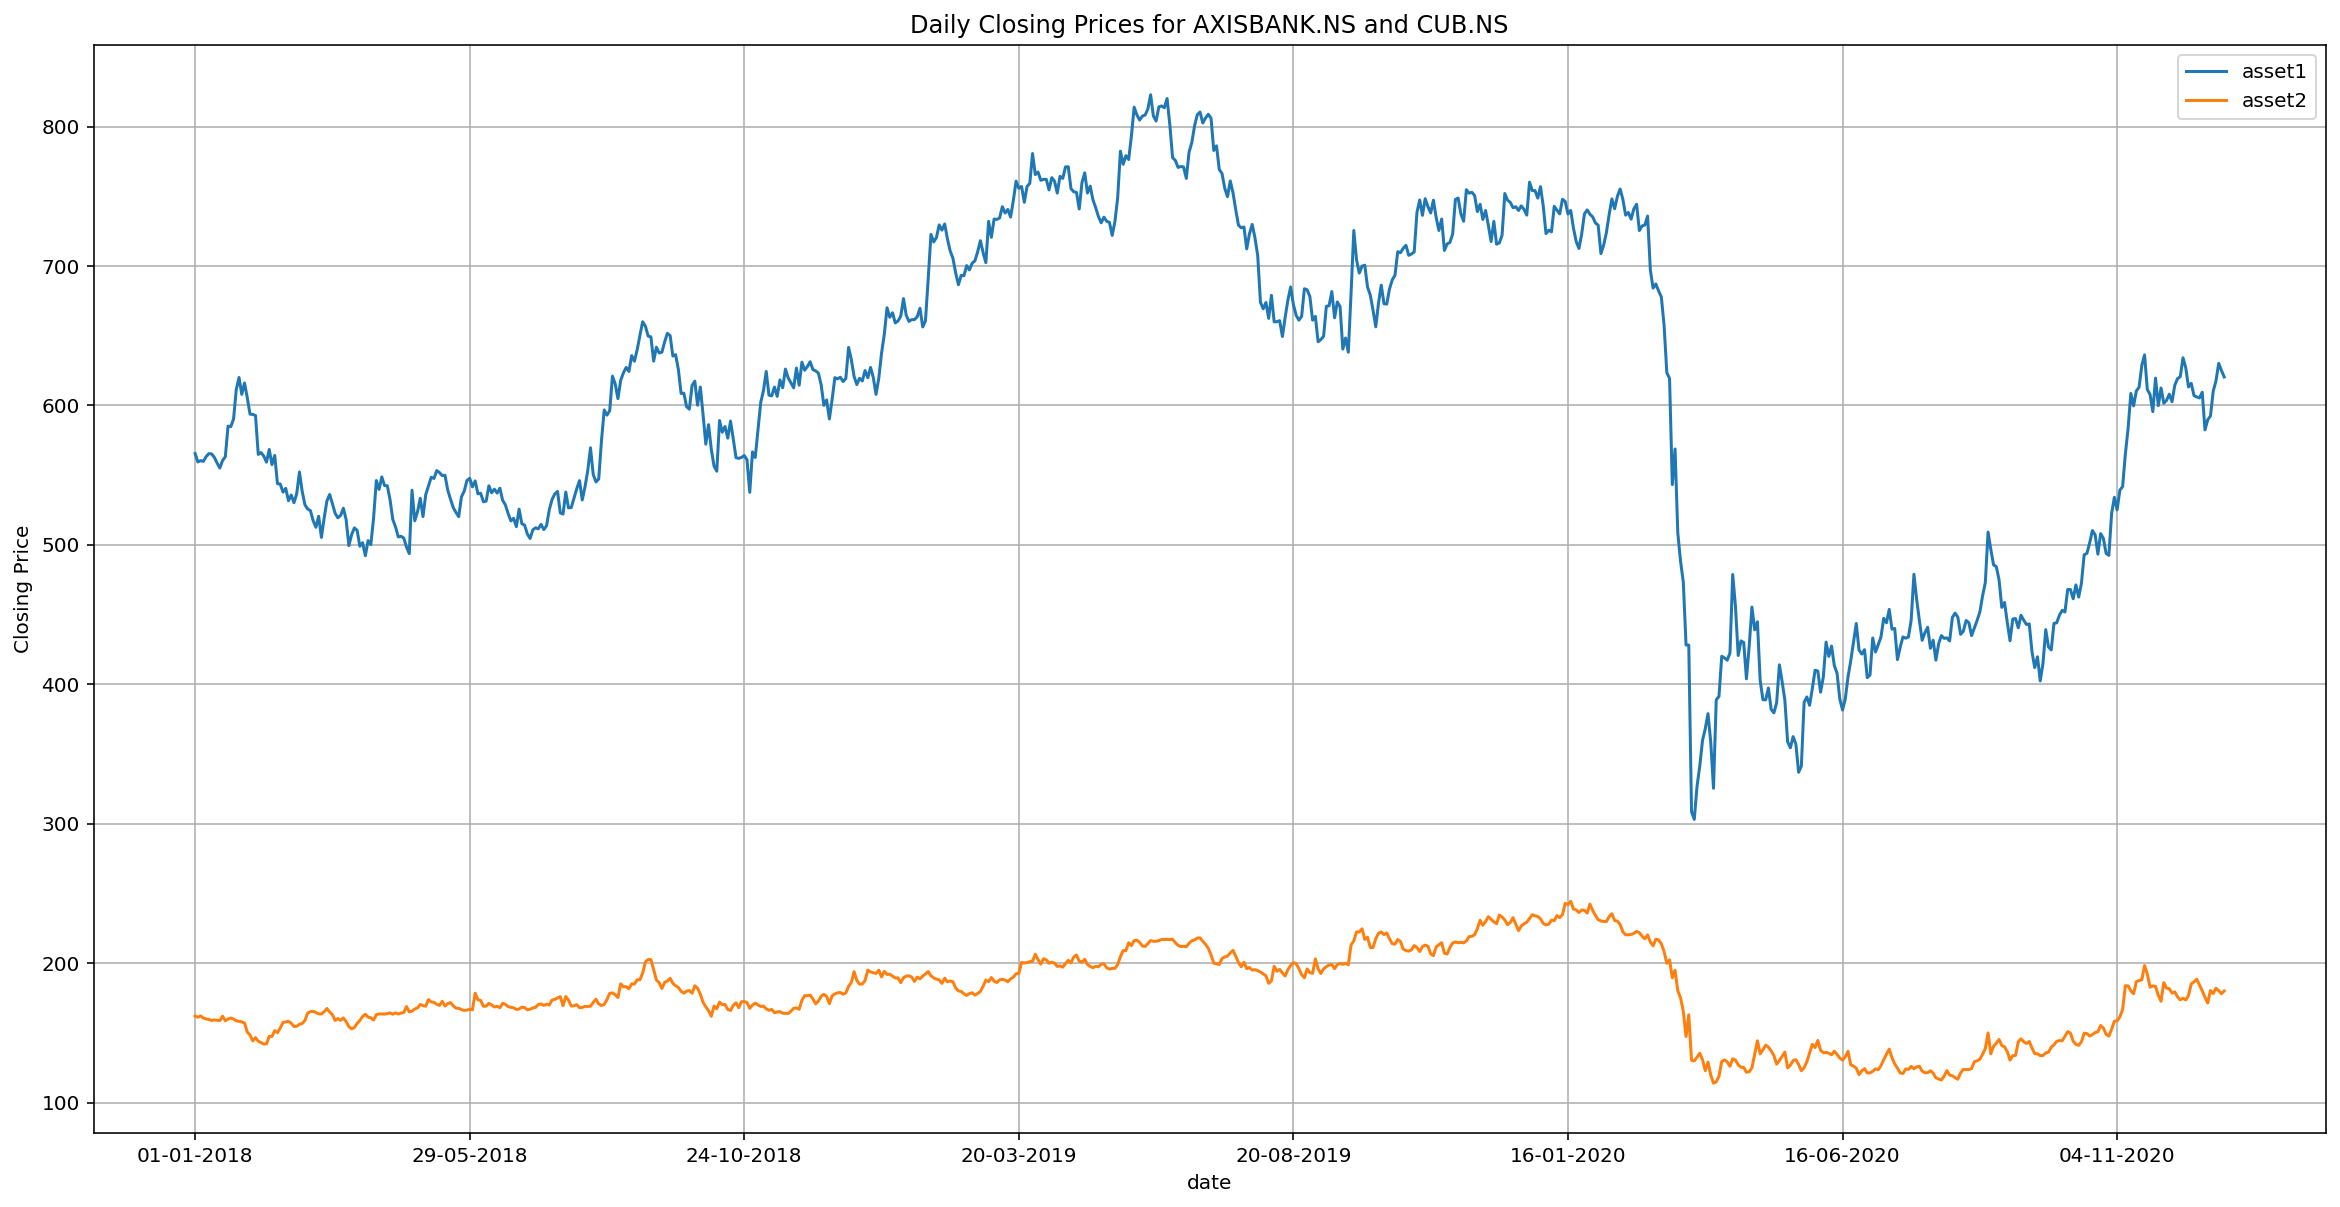

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.144e+05
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:20:48   Log-Likelihood:                         -3025.7
No. Observations:                 740   AIC:                                      6053.
Df Residuals:                     739   BIC:                                      6058.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.2928      0.001    338.159      0.000       0.291       0.294
==============================================================================
Omnibus:                       20.483   Durbin-Watson:                   0.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.060
Skew:                          -0.245   Prob(JB):                     0.000537
Kurtosis:                       2.501   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

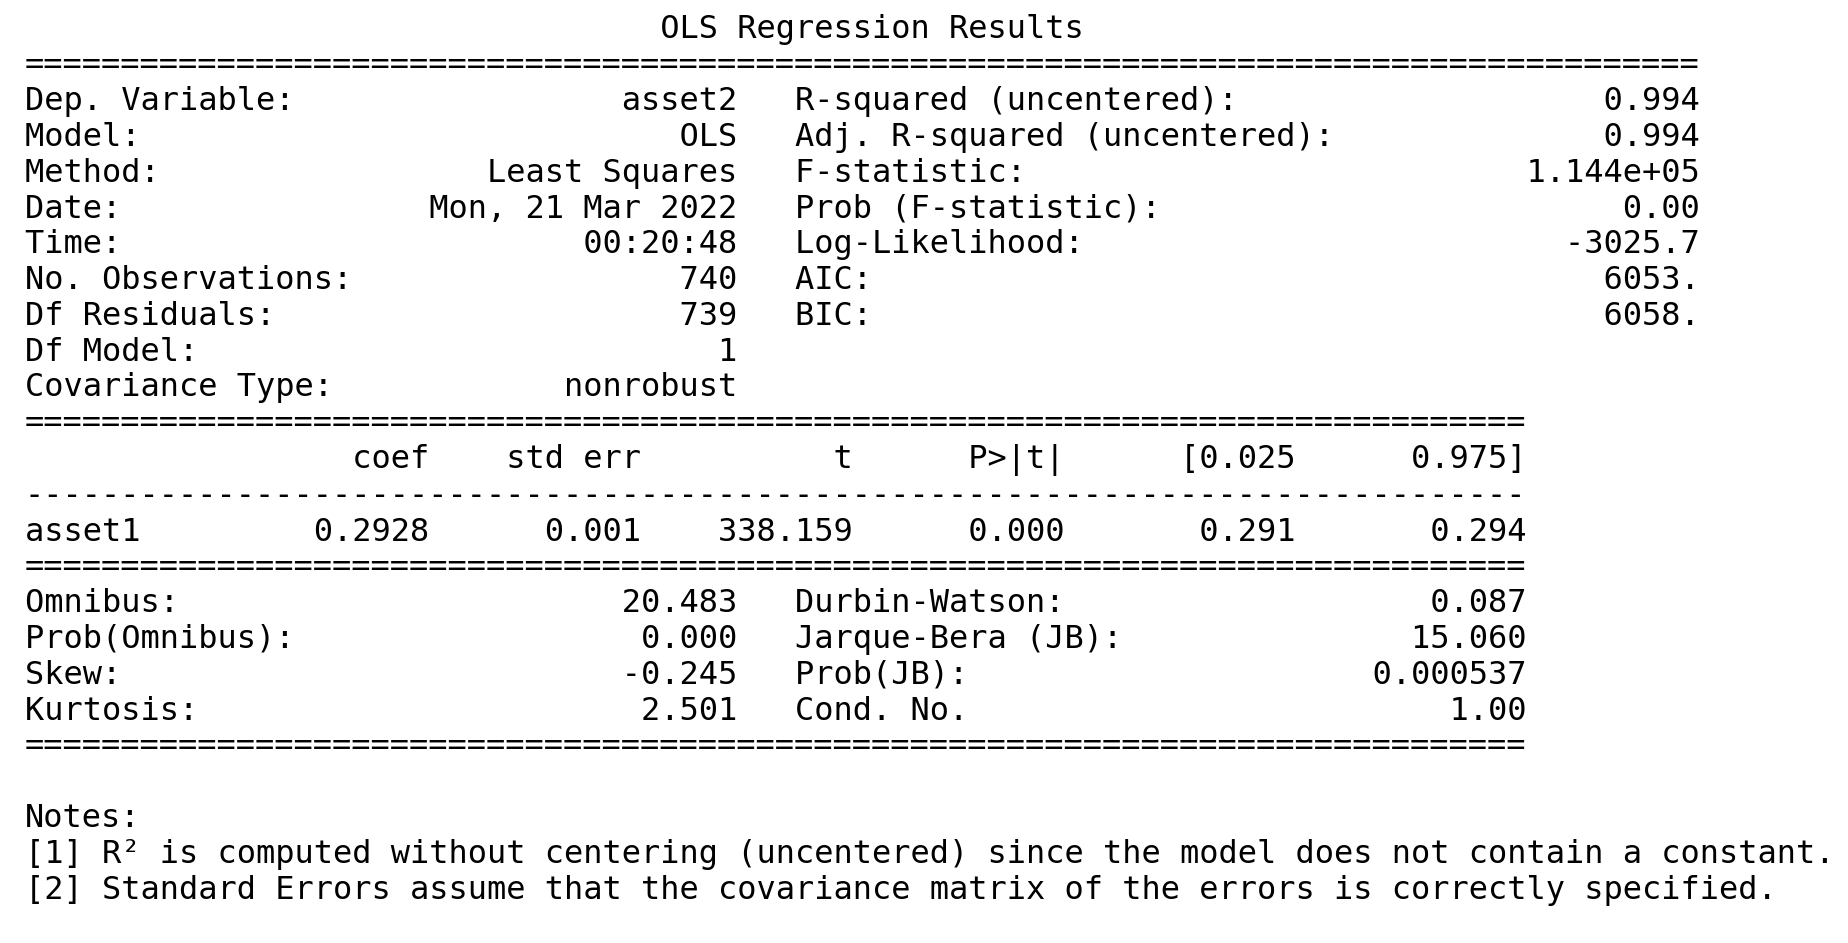

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.2927622579221333


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

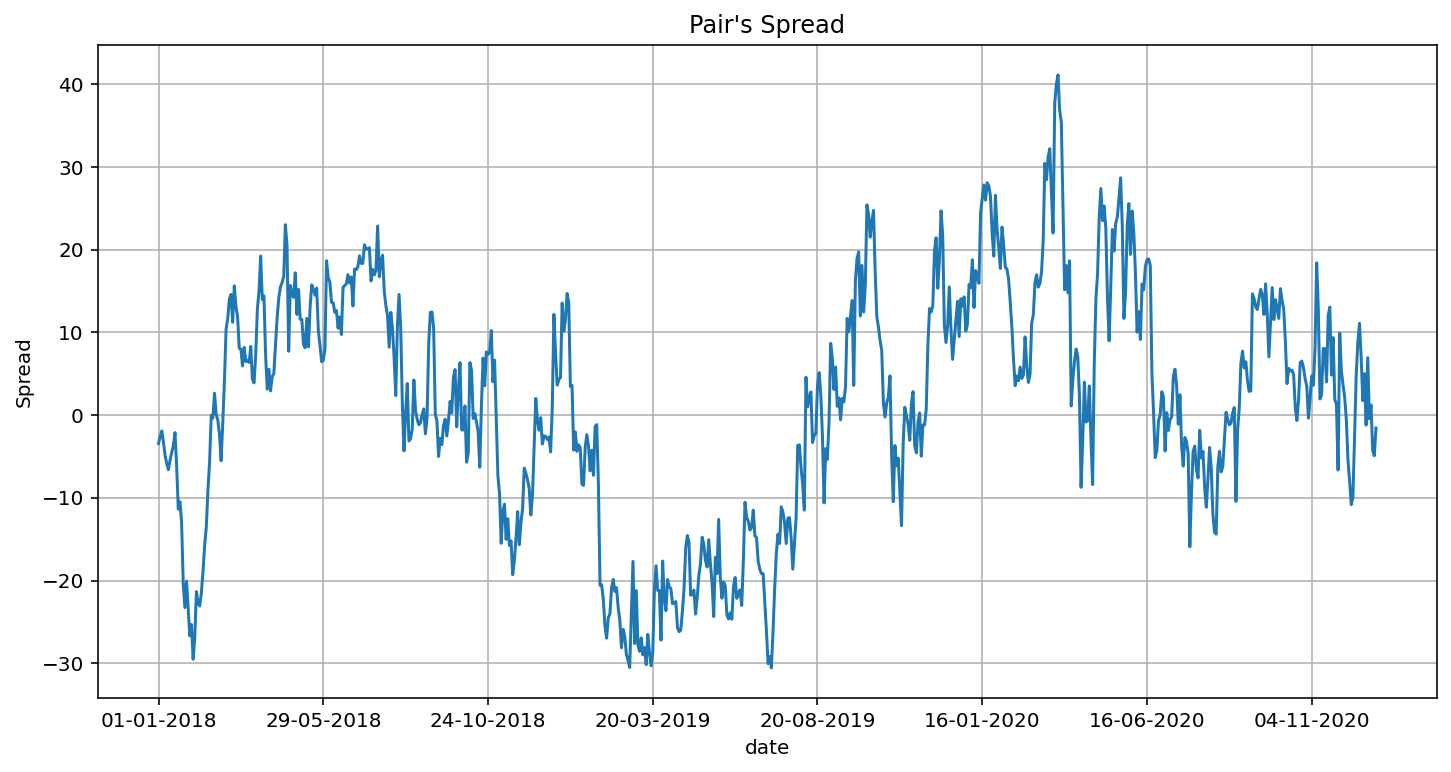

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-4.061575257998327,
 0.001120278496083099,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4219.206775724626)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -4.061575257998327


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  623.799988  180.449997
04-01-2021  624.700012  179.100006
05-01-2021  664.450012  182.649994
06-01-2021  654.250000  182.649994
07-01-2021  671.099976  184.949997

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  623.799988  180.449997 -2.713122            1.0           -1.0
04-01-2021  624.700012  179.100006 -2.634622            1.0           -1.0
05-01-2021  664.450012  182.649994 -2.256201            1.0           -1.0
06-01-2021  654.250000  182.649994 -2.397239            1.0           -1.0
07-01-2021  671.099976  184.949997 -2.279648            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

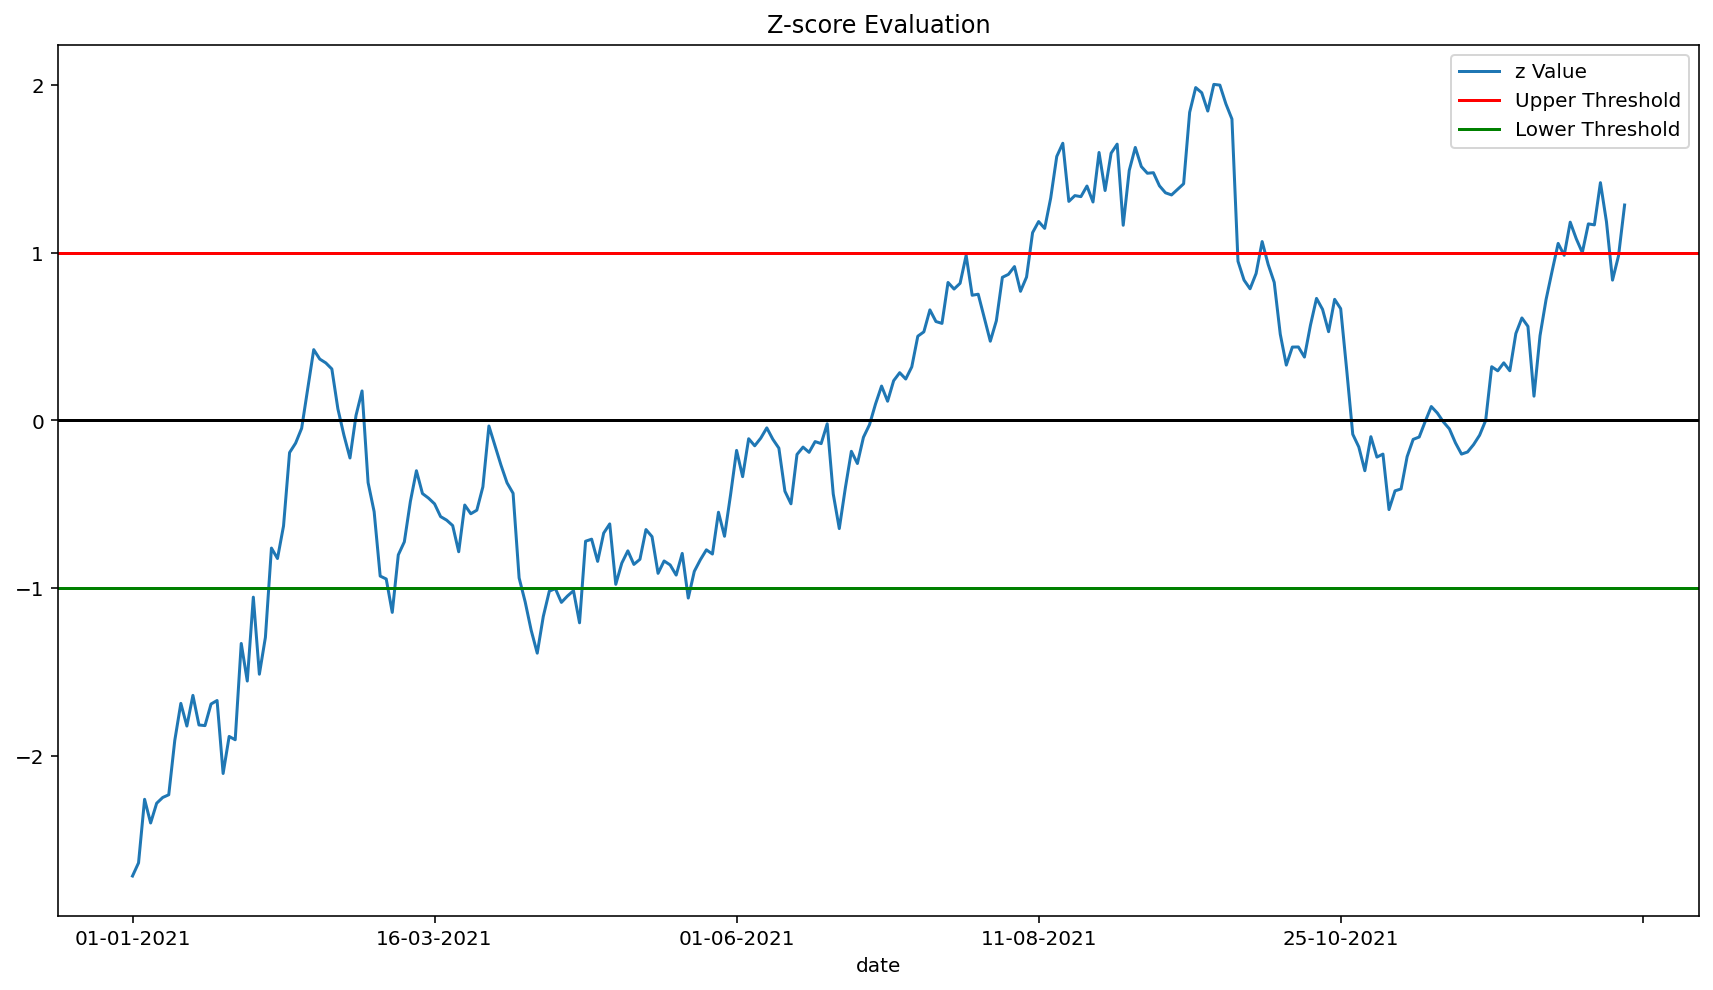

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  623.799988  180.449997 -2.713122            1.0           -1.0   
04-01-2021  624.700012  179.100006 -2.634622            1.0           -1.0   
05-01-2021  664.450012  182.649994 -2.256201            1.0           -1.0   
29-12-2021  670.500000  137.899994  0.836063            1.0           -1.0   
30-12-2021  668.849976  135.949997  0.981546            1.0           -1.0   
31-12-2021  678.549988  134.649994  1.283447            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021        -1        -1.0         1         1.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  623.799988  180.449997 -2.713122            1.0           -1.0   
04-01-2021  624.700012  179.100006 -2.634622            1.0           -1.0   
05-01-2021  664.450012  182.649994 -2.256201            1.0           -1.0   
06-01-2021  654.250000  182.649994 -2.397239            1.0           -1.0   
07-01-2021  671.099976  184.949997 -2.279648            1.0           -1.0   
08-01-2021  672.700012  184.699997 -2.245365            1.0           -1.0   
11-01-2021  666.950012  182.800003 -2.229200            1.0           -1.0   
12-01-2021  675.700012  178.899994 -1.904798            1.0           -1.0   
13-01-2021  687.799988  178.000000 -1.684887            1.0           -1.0   
14-01-2021  676.000000  177.399994 -1.819871            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  623.799988  180.449997 -2.713122            1.0           -1.0   
04-02-2021  743.900024  175.850006 -0.759862            1.0           -1.0   
04-03-2021  736.799988  180.649994 -1.143002            1.0           -1.0   
05-03-2021  730.750000  173.399994 -0.800436            1.0           -1.0   
08-04-2021  681.599976  166.100006 -1.079997            1.0           -1.0   
20-12-2021  674.349976  134.899994  1.181229            1.0           -1.0   
22-12-2021  669.349976  135.850006  0.999987            1.0           -1.0   
23-12-2021  678.799988  135.899994  1.171029            1.0           -1.0   
29-12-2021  670.500000  137.899994  0.836063            1.0           -1.0   
31-12-2021  678.549988  134.649994  1.283447            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-02-2021         0        -1.0         0         1.0  
04-03-2021         1         1.0        -1        -1.0  
05-03-2021         0        -1.0         0         1.0  
08-04-2021         1         1.0        -1        -1.0  
20-12-2021        -1        -1.0         1         1.0  
22-12-2021         0         1.0         0        -1.0  
23-12-2021        -1        -1.0         1         1.0  
29-12-2021         0         1.0         0        -1.0  
31-12-2021        -1        -1.0         1         1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

736.799988    1
681.599976    1
705.900024    1
782.150024    1
778.950012    1
688.900024    1
669.349976    1
670.500000    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  623.799988  180.449997 -2.713122            1.0           -1.0   
04-01-2021  624.700012  179.100006 -2.634622            1.0           -1.0   
05-01-2021  664.450012  182.649994 -2.256201            1.0           -1.0   
06-01-2021  654.250000  182.649994 -2.397239            1.0           -1.0   
07-01-2021  671.099976  184.949997 -2.279648            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  672.150024  132.000000  1.416504            1.0           -1.0   
28-12-2021  675.450012  135.100006  1.183102            1.0           -1.0   
29-12-2021  670.500000  137.899994  0.836063            1.0           -1.0   
30-12-2021  668.849976  135.949997  0.981546            1.0           -1.0   
31-12-2021  678.549988  134.649994  1.283447            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021        -1        -1.0         1         1.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

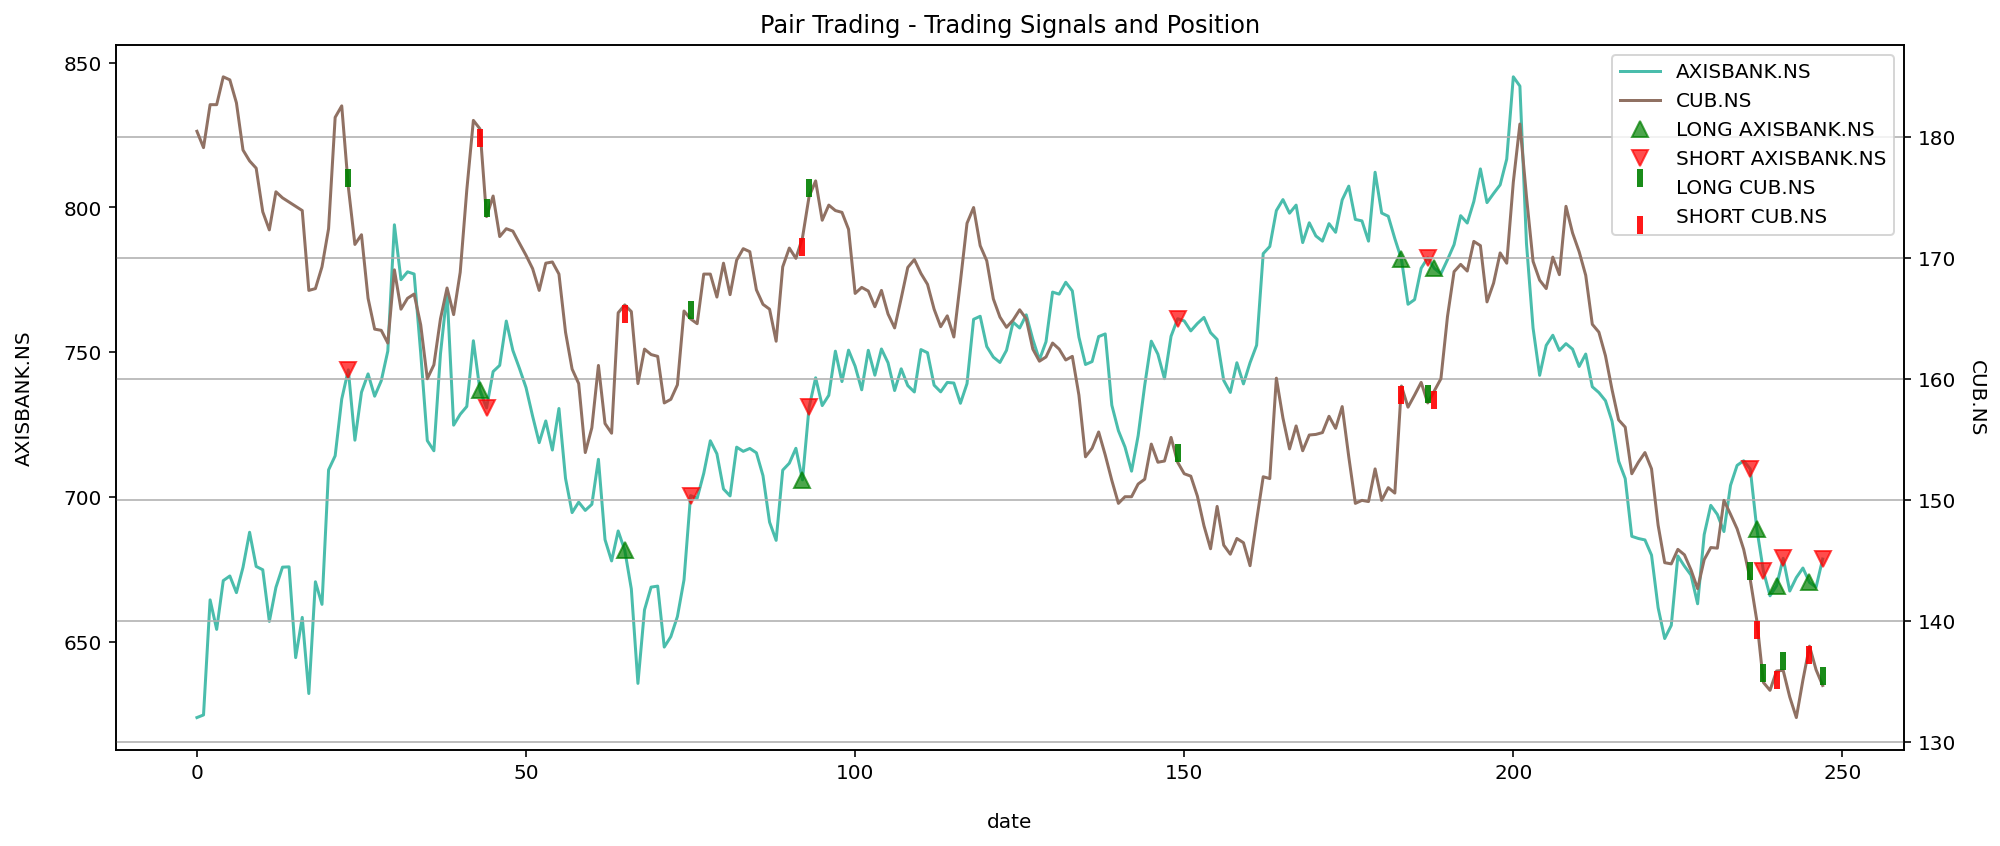

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    623.799988            NaN            NaN            NaN       NaN   
1    624.700012       0.000000  100000.000000  100000.000000       NaN   
2    664.450012       0.000000  100000.000000  100000.000000  0.000000   
3    654.250000       0.000000  100000.000000  100000.000000  0.000000   
4    671.099976       0.000000  100000.000000  100000.000000  0.000000   
243  672.150024 -158627.405758  273377.398560  114749.992802 -0.009473   
244  675.450012 -159406.202879  273377.398560  113971.195681 -0.006787   
245  670.500000  -79119.000000  194258.398560  115139.398560  0.010250   
246  668.849976  -78924.297121  194258.398560  115334.101440  0.001691   
247  678.549988 -160137.797121  274327.297121  114189.500000 -0.009924   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         1.0  
246         0.0  
247        -1.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   623.799988           NaN            NaN            NaN           NaN   
23  743.900024 -87780.202879  187780.202879  100000.000000 -1.110223e-16   
43  736.799988      0.000000  100837.804319  100837.804319  2.047990e-02   
44  730.750000 -86228.500000  187066.304319  100837.804319 -1.110223e-16   
65  681.599976      0.000000  106637.507198  106637.507198  7.413152e-03   

    positions1  
0          NaN  
23        -1.0  
43         1.0  
44        -1.0  
65         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    623.799988            NaN            NaN            NaN       NaN   
1    624.700012       0.000000  100000.000000  100000.000000       NaN   
2    664.450012       0.000000  100000.000000  100000.000000  0.000000   
3    654.250000       0.000000  100000.000000  100000.000000  0.000000   
4    671.099976       0.000000  100000.000000  100000.000000  0.000000   
243  672.150024 -158627.405758  273377.398560  114749.992802 -0.009473   
244  675.450012 -159406.202879  273377.398560  113971.195681 -0.006787   
245  670.500000  -79119.000000  194258.398560  115139.398560  0.010250   
246  668.849976  -78924.297121  194258.398560  115334.101440  0.001691   
247  678.549988 -160137.797121  274327.297121  114189.500000 -0.009924   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  180.449997            NaN            NaN            NaN   
1           0.0  179.100006       0.000000  100000.000000  100000.000000   
2           0.0  182.649994       0.000000  100000.000000  100000.000000   
3           0.0  182.649994       0.000000  100000.000000  100000.000000   
4           0.0  184.949997       0.000000  100000.000000  100000.000000   
243         0.0  132.000000  142560.000000  -63025.996706   79534.003294   
244         0.0  135.100006  145908.006588  -63025.996706   82882.009882   
245         1.0  137.899994   74465.996706   11440.000000   85905.996706   
246         0.0  135.949997   73412.998326   11440.000000   84852.998326   
247        -1.0  134.649994  145421.993412  -61270.996706   84150.996706   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.022564         0.0  
244  0.042095         0.0  
245  0.036485        -1.0  
246 -0.012258         0.0  
247 -0.008273         1.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   623.799988           NaN            NaN            NaN           NaN   
23  743.900024 -87780.202879  187780.202879  100000.000000 -1.110223e-16   
43  736.799988      0.000000  100837.804319  100837.804319  2.047990e-02   
44  730.750000 -86228.500000  187066.304319  100837.804319 -1.110223e-16   
65  681.599976      0.000000  106637.507198  106637.507198  7.413152e-03   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  180.449997           NaN            NaN            NaN   
23        -1.0  175.850006  94959.003294    5040.996706  100000.000000   
43         1.0  180.649994      0.000000  102591.993412  102591.993412   
44        -1.0  173.399994  93635.996706    8955.996706  102591.993412   
65         1.0  166.100006      0.000000   98650.000000   98650.000000   

     return2  positions2  
0        NaN         NaN  
23  0.000000         1.0  
43 -0.003671        -1.0  
44  0.000000         1.0  
65  0.003571        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

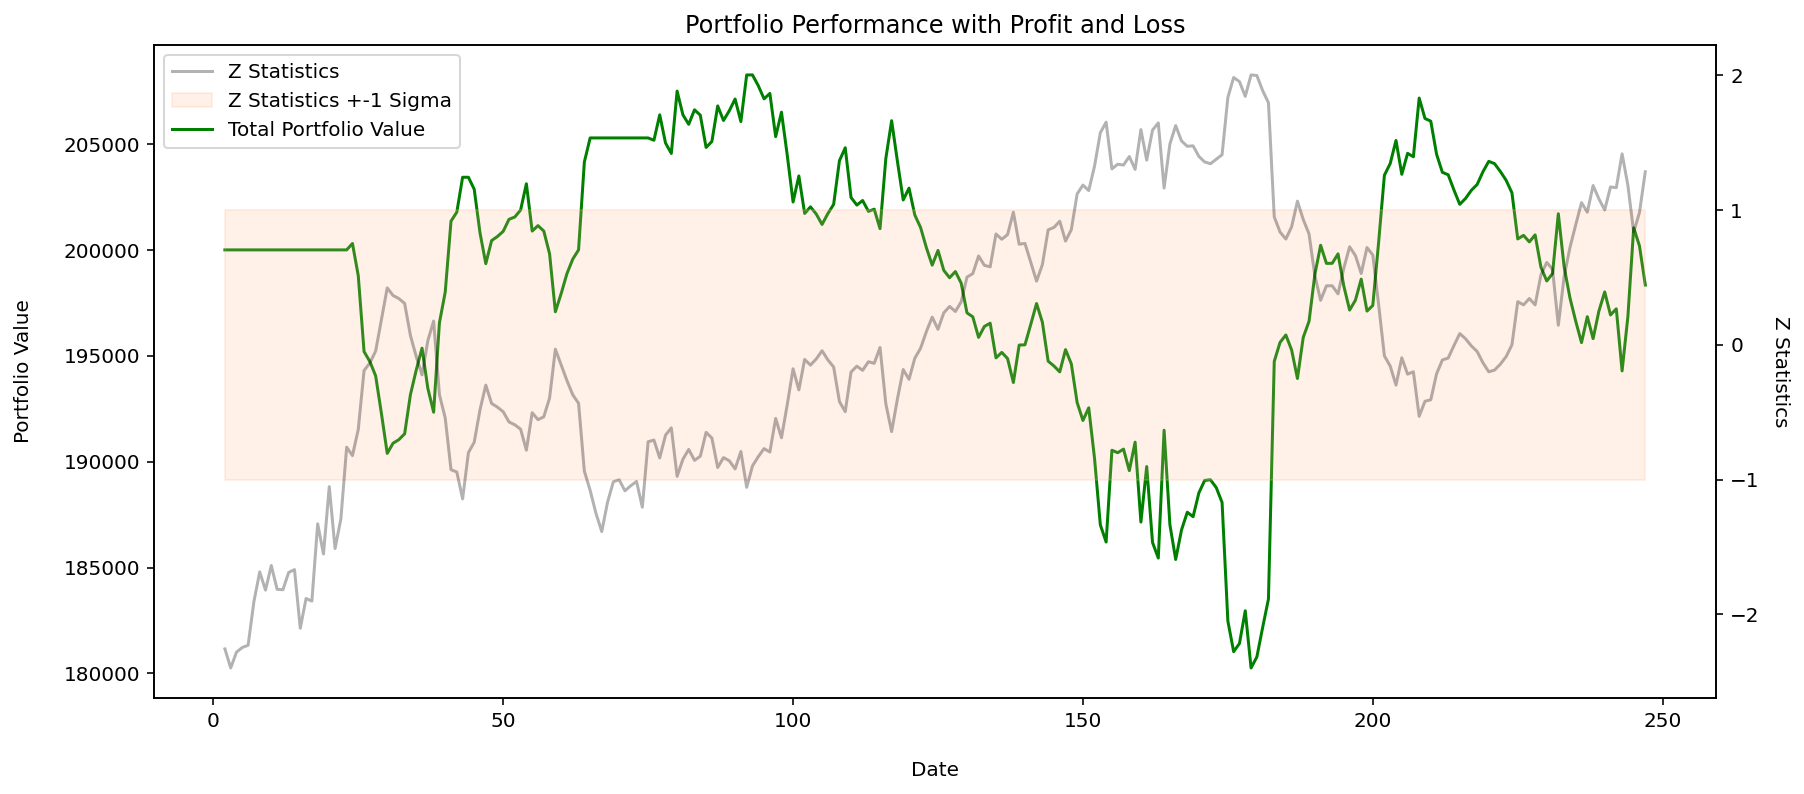

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

198340.496706

In [48]:
profit = final_portfolio - 2*initial_capital
profit

-1659.5032939999946

In [49]:
roi = (profit/(2*initial_capital))*100
roi

-0.8297516469999973

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 177.385%
